<style>
    .div-1 {
        background-color: #EBEBEB;
    }
    
    .div-2 {
    	background-color: #ABBAEA;
    }
    
    .div-3 {
    	background-color: #FBD603;
    }
</style>

<div align="right"><img src='https://blockchain4talent.com/wp-content/uploads/2021/09/a58ab6e0efdce2743f592019683b00c2.jpeg'>

<h1 style="color:#2596be;font:luminary;text-align:center;"><i>Cisco Project</i></h1>

<div class=“alert alert-success”>

<h2 style="color:#2596be;">Project's Description</h1> 

This team was tasked to build a model that can predict the sales for Cisco. Our goal is to explore historical Cisco sales to Texas public agencies (school districts, government agencies, municipalities, etc) to present to people who might want to buy into the cisco ecosystem if it is a good idea going forward.

In this project we will focus on the __Time Series Analysis__ and we will attempt to create a forecast model that can predict future sales.

In [133]:
# project modules
import src.wrangle as wr
import src.explore as ex
import src.summaries as s
import src.ts_models_d as tsmd
import src.decomposition as d

from importlib import reload

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
# makes vizualizations better in a jupyter notebook
%config InlineBackend.figure_format = 'retina'

<h3 style="color:#2596be;">Acquire and Prepare</h3> 

We acquired the data from the [Texas Open Data Portal](https://data.texas.gov/dataset/OFFICIAL-DIR-Cooperative-Contract-Sales-Data-Fisca/w64c-ndf7). The origin of the data is 	[Texas Department of Information Resources](	https://dir.texas.gov/). The data file contains information about DIR (Department of Information Resources) Cooperative Contract Sales. To get the information about Cisco we filtered the data by vendor name.

1. **Acquire** Our first cleaning step was dropping the  7 columns with null values only and renaming columns into programming friendly format simply by replacing whitespaces with underscores and making them lower case. Our next step was dropping columns with no value for exploration or modeling purposes (for example, `vendor_adress`, `reseller_phone` etc.)

*Access the data:* `df = wr.acquire_data()`

2. **Clean** We have created additional features based on the `order_date` information:
    `year` : year
    `quarter`: quarter
    `month`: month number
    `month_name`: month name
    `day_of_week`: day of week number
    `day_name`: day of week name
    `day_of_year`: day of the year
    `week`: week of the year number

*Access the data:* `wr.get_clean_data()`

3. **Prepare** The original data set had two issues. First, there was lots of missing data in 2017. We took decision to remove all available data for 2017 and  add one year to everything before. Second, the original data contains the accounting information about every transaction where every row represents a transaction. One company could have many transactions per day, including those where the `purchase_amount` was equal to zero, one cent or being negative. To fix this issue and make the data more readable we have created as well a summary data frame whith the final `purchase_amount` per day per company. This combined the number of rows from 261,886 to 34,401 rows. 

*Access the data:* `df = s.get_summary_df(wr.get_clean_data())`


- Outliers were kept for this iteration of explore of modeling.
- To avoid data leakagee divided the data into train and test sets. 
- After the exploration we split the test set into validation and test sets as well.
    - `train` set contains data from May, 6 2014 till Dec, 31 2021 (without 2017)
    - `validate` set contains data from Jan, 1 2022 till Jun, 30 2022
    - `test` set contains data from July, 1 2022 till November, 29 2022
    
- __The target variable of the project is ```purchase_amount```__


<h3 style="color:#2596be;">Data Exploration</h3> 

### 1. How the purchase amount is changing over the time?

Before we jump into Data Exploration let's have a quick look at the day by day purchase amount change. On the graph below we can see that the daily purchase amount doesn't have any seasonality that can be observed. There is also no trend in the data. The spikes are pretty inconsistent and overall purchase amount looks like so called 'noise'. 

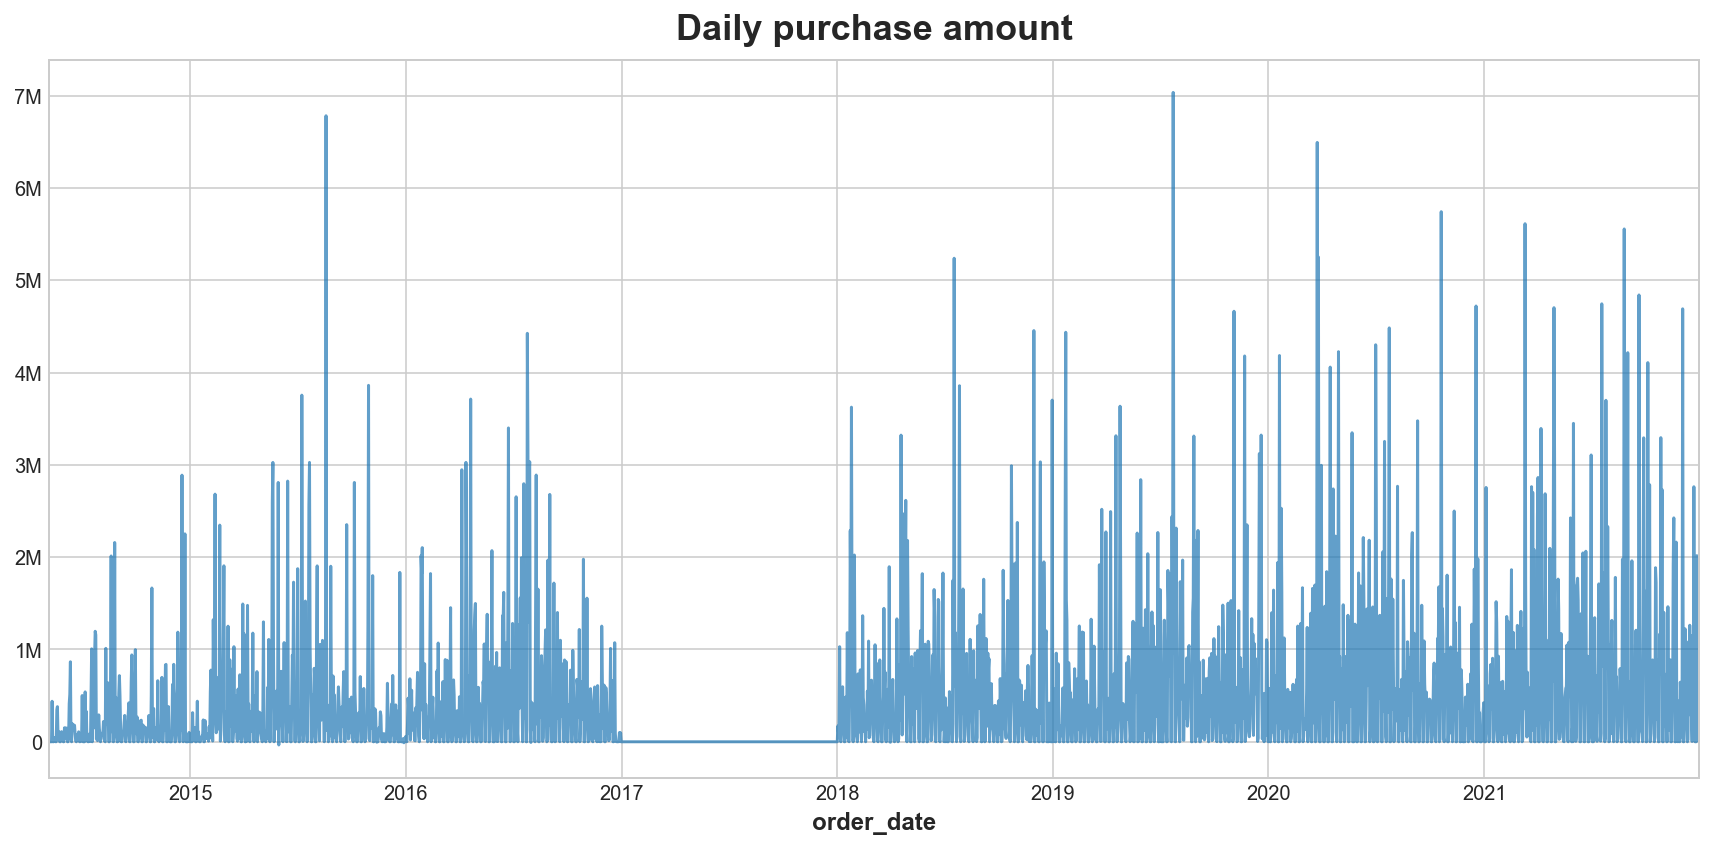

In [219]:
# purchase amount before merging
ex.q1_show_ts()

#### Takeaways:
- The purchase amount doesn't show the seasonality or trend.
- There is lots of missing data in 2017. It would negatively affect models, and provide incorrect information about the purchase amount. That's why we are going to remove 2017 and add one year to each year from 2014 till 2016.
- It looks more like `noise` data that is extremely hard to predict using traditional statistic methods.

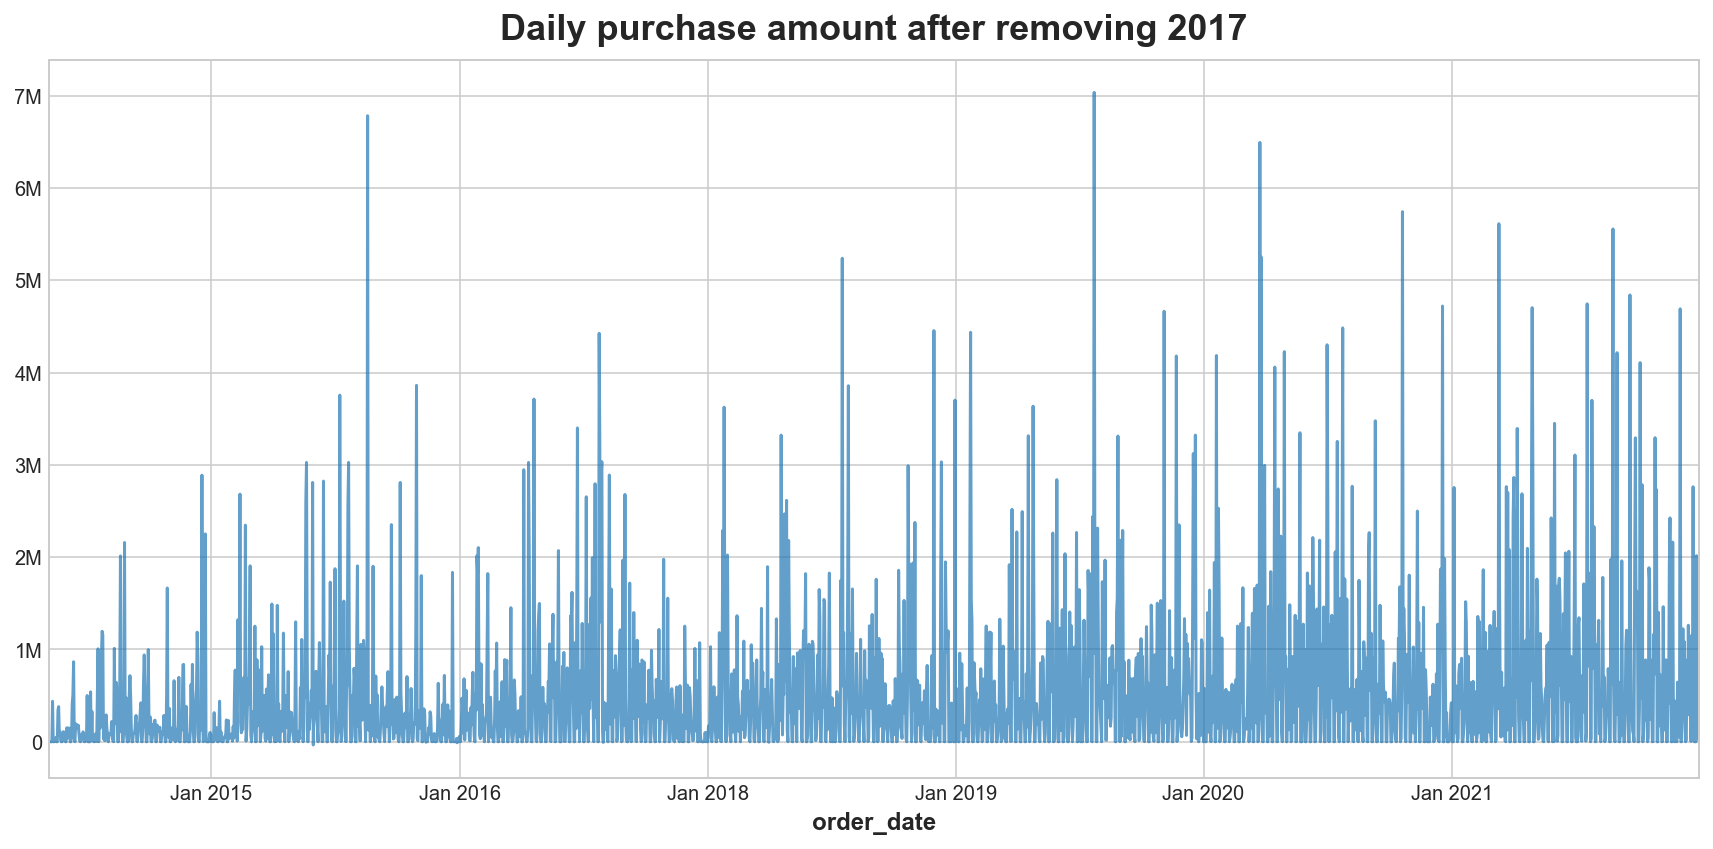

In [220]:
# show data with 2017 removed
ex.q1_show_merged_ts()

We for sure can not see any trend in daily purchase amount. It seems to be very messy. Way to many transactions are happening during the day. What if we calulate the total purchase amount by month? Can we find any pattern in the data?

#### Takeaway:
- There is missing data in 2017. We had to remove this year completely.
- Daily transactions look very messy and we can not see any pattern, trend, seasonality.

### Q2. Is there any trend in total purchase amount per month?

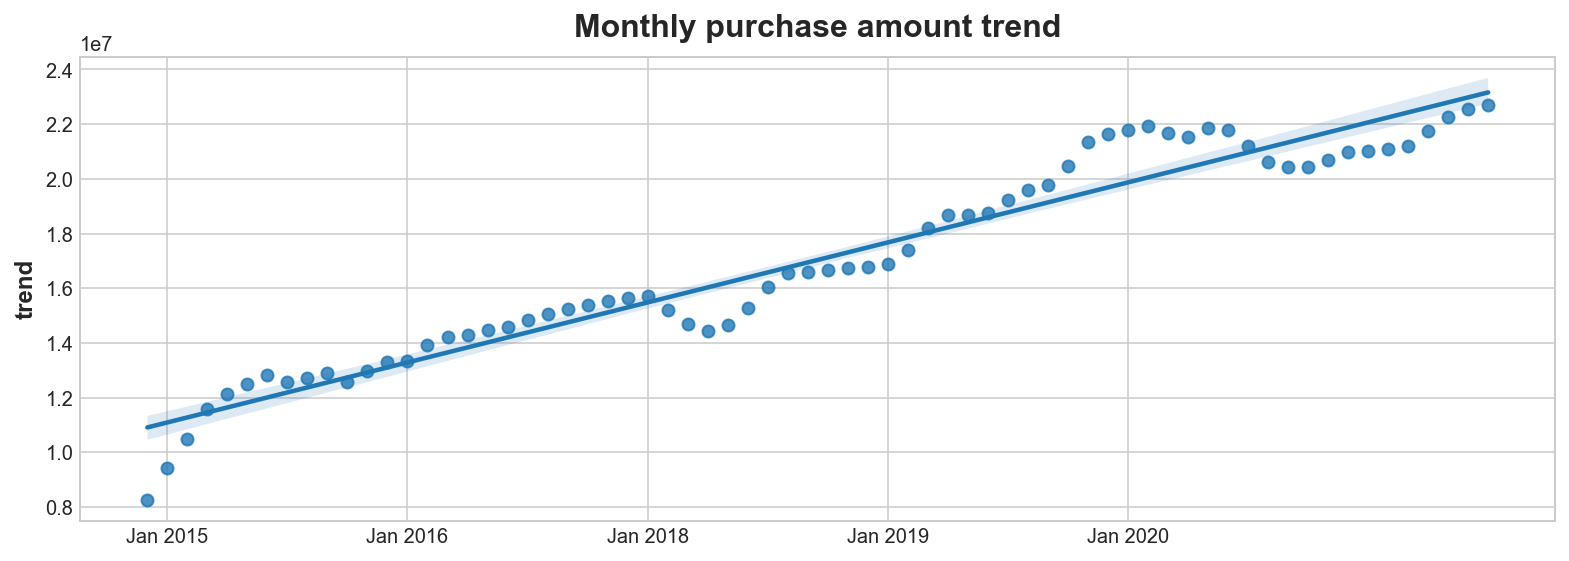

In [150]:
# show the monthly trend info
d.viz_monthly_trend()

#### Takeaway:
- After calculating the total monthly purchase amount we observed a clear positive trend in our taget variable. Specially during 2016
- In the beginning of 2018 the sales went down a lot. We don't know for sure if the beginning of 2018 was also affected by missing data or it is a real decrease in sales for Cisco. 
- The end of 2019 and beginning of 2020 there bring an increase in sales. This is the start of COVID-2019 pandemic. 
- Starting the middle of 2020 period sales drop back to the trend and even lower. If the values in validate and test sets continue to descrease, our future model going to overestimate the total purchase amount.

### Q3. What are the customer types represented in the data?

As you know, we are exploring historical Cisco sales to Texas public agencies, and what are those public agencies and what is their proportion?   We can see that most orders are made by Local Goverments, followed by  Independent School Districts, Higher Education Institutions and State Agencies. Other public agencies make only 0.4% orders.

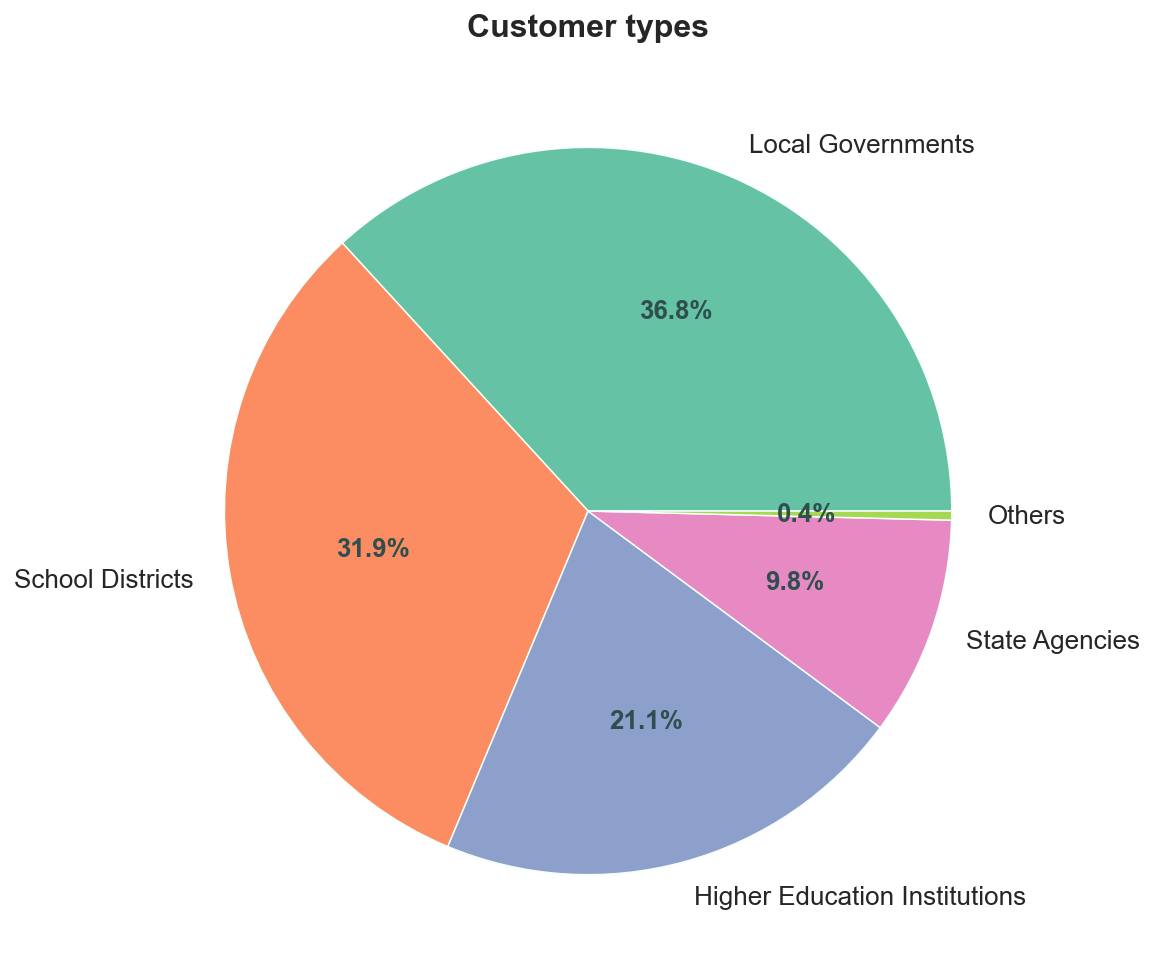

In [34]:
# call pie chart with 
ex.viz_customer_types()

#### Takaway:
- Cisco customers represented in DIR data set are divided into following groups:
    * Local Governments - 36.8%
    * Independent School Districts - 31.9 %
    * Higher Education Institutions - 21.1%
    * State Agencies - 9.8%
    * Other public agencies - 0.4%

### Q4. Is the trend the same for every customer type?

The short answer is "No". Local Governments and State Agenciesthe trends are absolutely the same, they form one line. School districts have very strong positive trend. Other category don't have any trend and their total purchase amounts are so little that we decided not to put them on the graph.

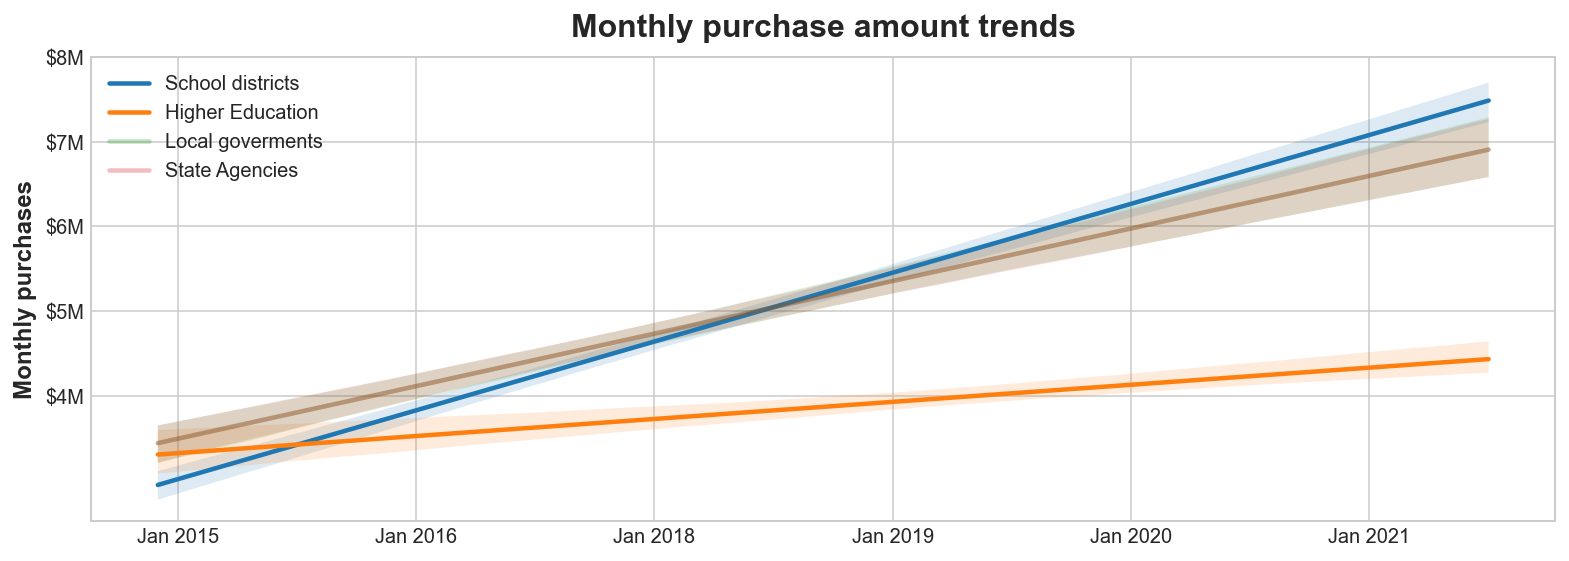

In [163]:
# show trends for schools, local governments, state agencies and 
d.show_all_trends()

The most interesting observation is Higher Educational Institutions. If we look to the whole data the trend is slightly positive. If we check the last years, the picture is completely different. Lately, their trend follows the opposite direction.

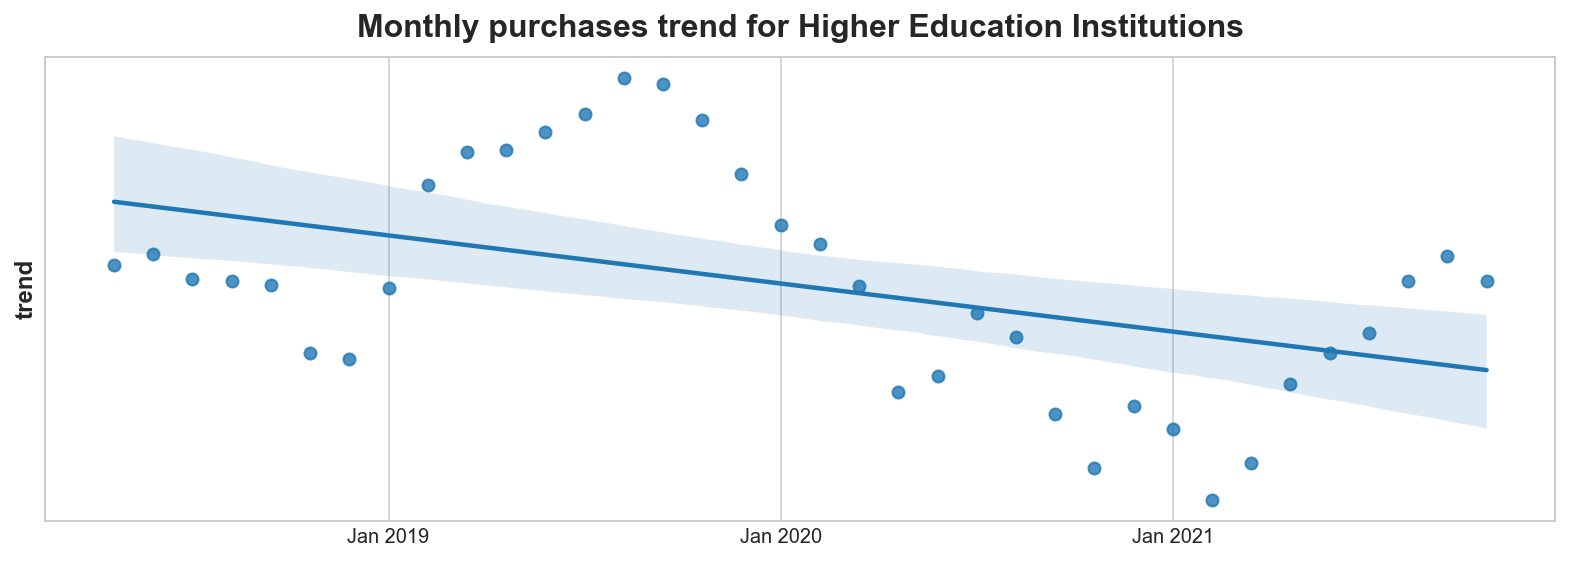

In [164]:
# show monthly trend for higher educations starting from 2018
d.show_hedu_trend2018()

#### Takaways:
- Local Governments and State Agencies follow the same trend.
- Higher Educational Institutions have less obvious trend line.
- Higher Educational Institutions have a negative trend after 2018.

We were curious if School Districts were buying Cisco products before pandemic or they started to by actively only in the lockdown period.

### Q5. Did School Districts have positive trend before COVID-2019?

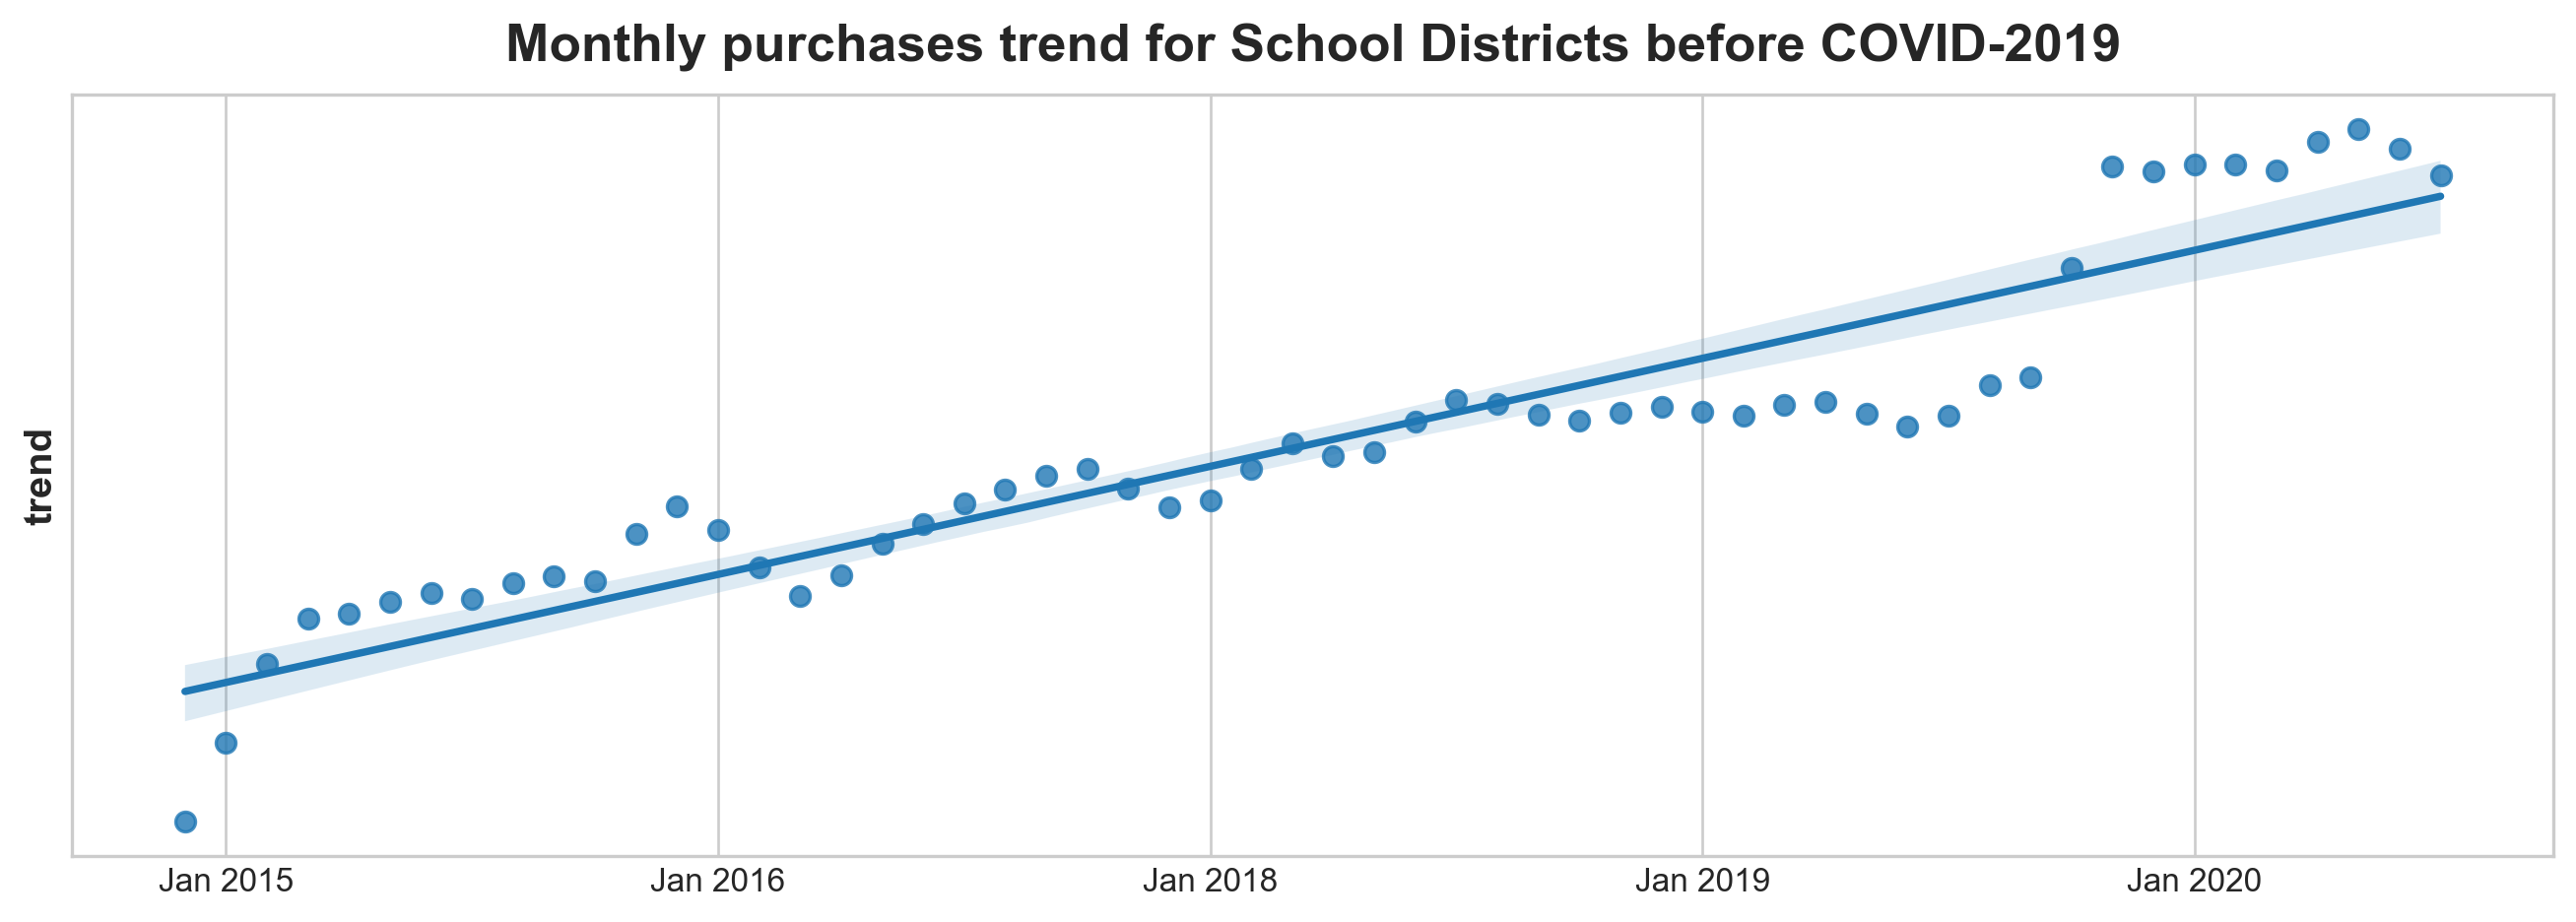

In [265]:
# show school trend before pandemic
d.show_school_trend_before()

There definitely was a positive trend. What about total monthly purchase amount by itself?

### Q6. How did monthly purchase amount change for school districts during the pandemic of COVID-2019?

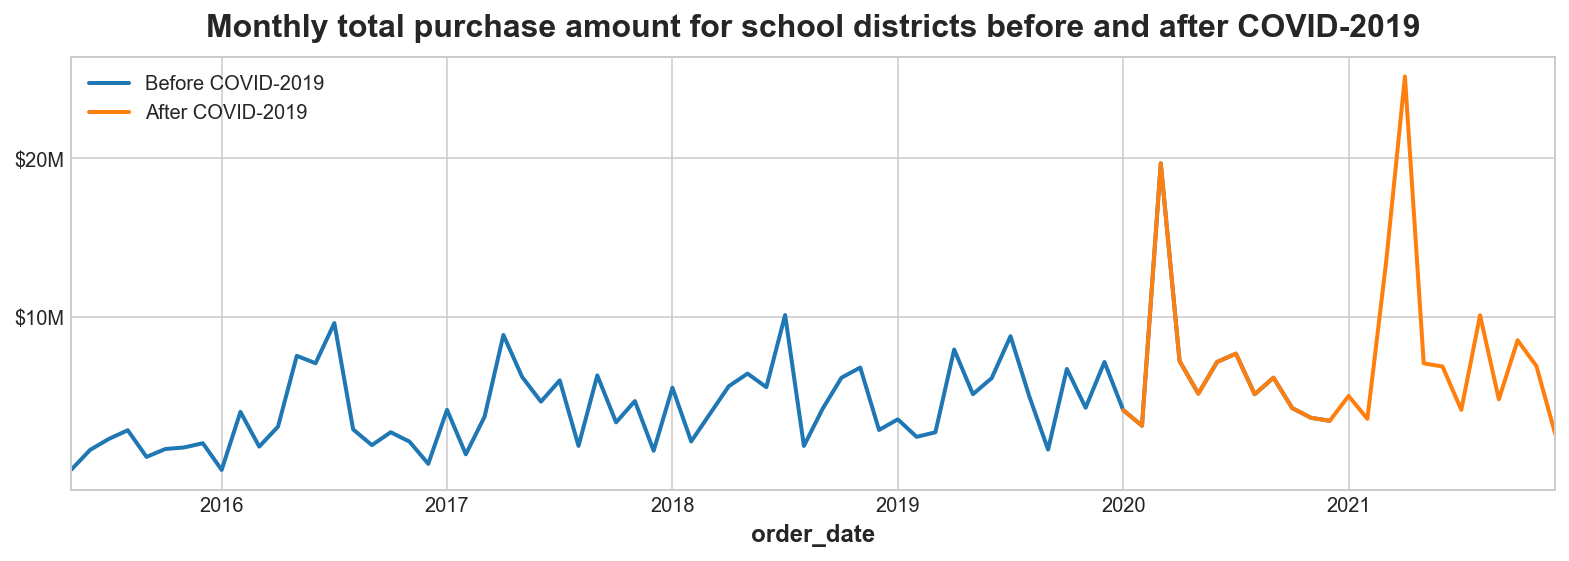

In [189]:
# show the total monthly purchases of school districts before and after pandemic
d.viz_school_purchases()

#### Takeaways from Q5 and Q6
- School districts where constantly buying Cisco products even before COVID-19. But since the beginning of pandemic their purchase amount at least doubled.

### Q7. Is there any significant difference in average of total purchase amounts by  day?

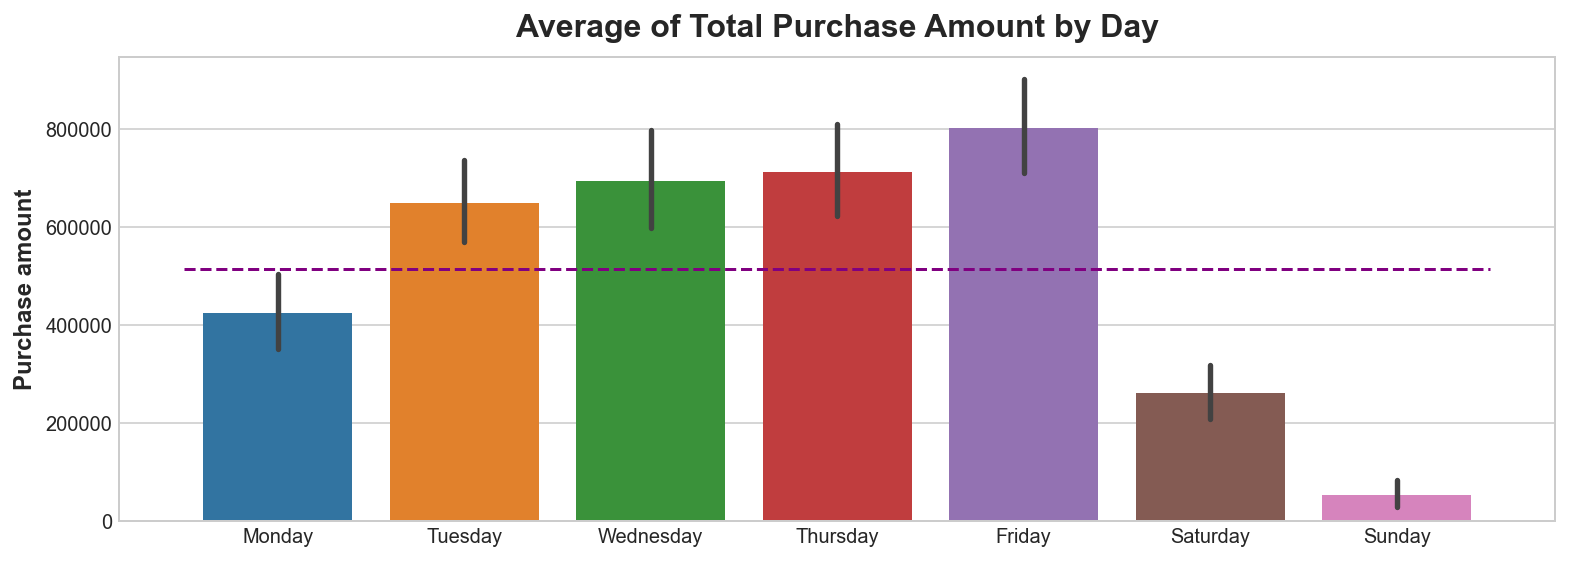

In [41]:
# visualize average sales per day
ex.q3_viz()

We can see a significant difference in purchase amount between weekdays and weekends. The daily  average  of total purchase amount is plotted as a horizontal purple dashed line. Based on this graph we want to run two statistical tests. We will check if the average of total purchase amount by day is different from average of weekly purchase amounts. Next we will look into the averages of total purchase amount of Monday through Wednesday and see if there is a difference in their averages.

For statistical tests:

- $H_0:$ stands for 'Null hypothesis’ 
- $H_a:$ stands for 'Alternative hypotheses'

- All statistical tests run for the **95% Confidence level**.
- The **significance level** (alpha) is set to **0.05**
- If the p-value is smaller than 0.05 we reject the Null hypothesis.

#### Test #1

$H_0$: There is no significant difference in average total purchase amount by day  and average of weekly purchase amounts.

$H_a$: There is a significant difference in average total purchase amount by day  and average of weekly purchase amounts.

We use one sample T-test to compare average of weekly purchase amounts of an independent sample against the population average of weekly purchase amounts.

In [201]:
# call ttest for every day of the week
ex.q3_ttest()

,T-value,P-value
Day,,
Monday,-0.30,0.76
Tuesday,3.09,0.00
Wednesday,4.36,0.00
Thursday,4.51,0.00
Friday,5.85,0.00
Saturday,-12.88,0.00
Sunday,-41.91,0.00


All days showed a significant difference. For every day of the week we reject the null hypothesis.

#### Takeaways:
- All daily purchase amounts are significantly different from the average of weekly purchase amounts 
- Week days have higher average purchase amounts compared to average of weekly purchase amounts
- Weekend days and Mondays purchase amounts are well below average of weekly purchase amounts
- Friday has the highest average sales amount among all days of the week.

### Q8. Is there any significant difference in average of total purchase amount by month?

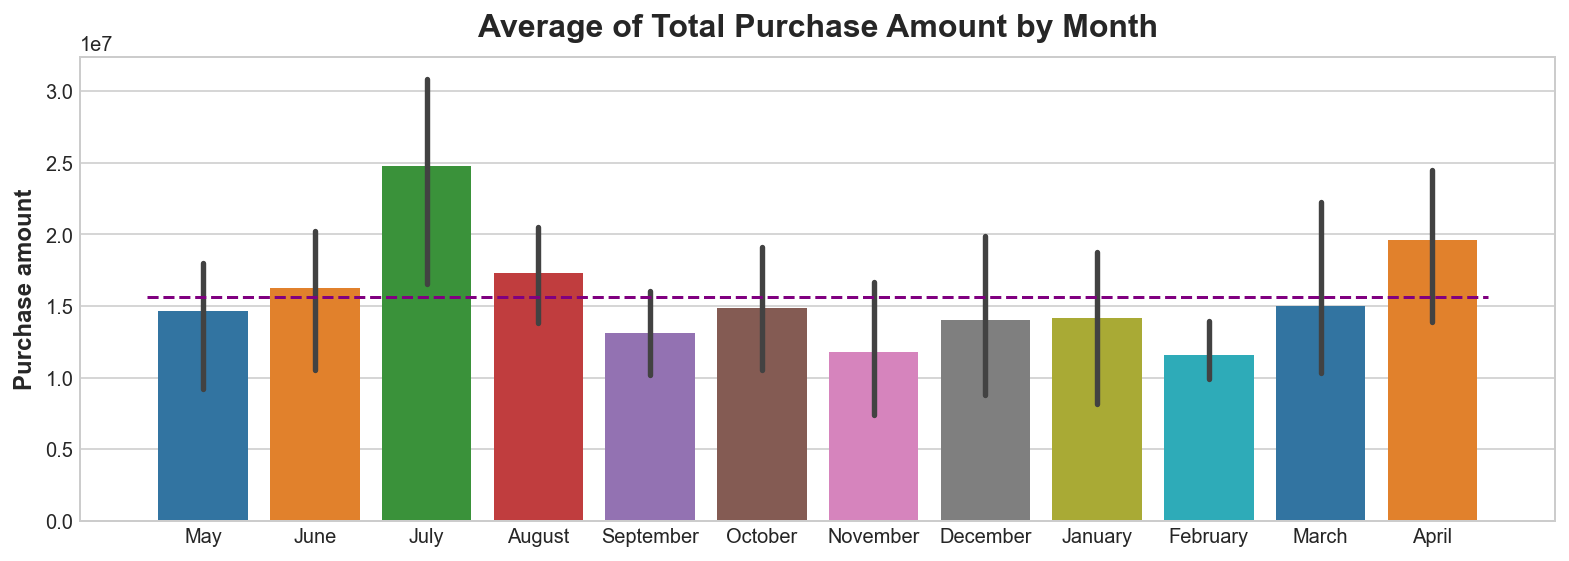

In [44]:
# show average sales per month
ex.q4_viz()

It seems that July has the largest average purchase amount and February has the lowest average purchase amount.

__One sample T-test to check if the average sales per month differ from average monthly sales.__

$H_0$: There is no significant difference in  average of total purchase  per month and average yearly purchase amount.

$H_a$: There is a significant difference in  average of total purchase  per month and average yearly purchase amount.

In [45]:
# run statistical test for every month
ex.q4_ttest()

,T-value,P-value
Month,,
July,2.28,0.07
April,1.40,0.23
August,0.86,0.43
June,0.23,0.83
March,-0.17,0.88
October,-0.29,0.78
May,-0.36,0.73
January,-0.45,0.68
December,-0.52,0.62


#### Takaways:
- Only February is significantly different from the average monthly purchase amount. February has the lowest number of sales.
- July and April have the highest amount of sales.

### Q9. Is there any significant difference in purchase amount  by the quarter?

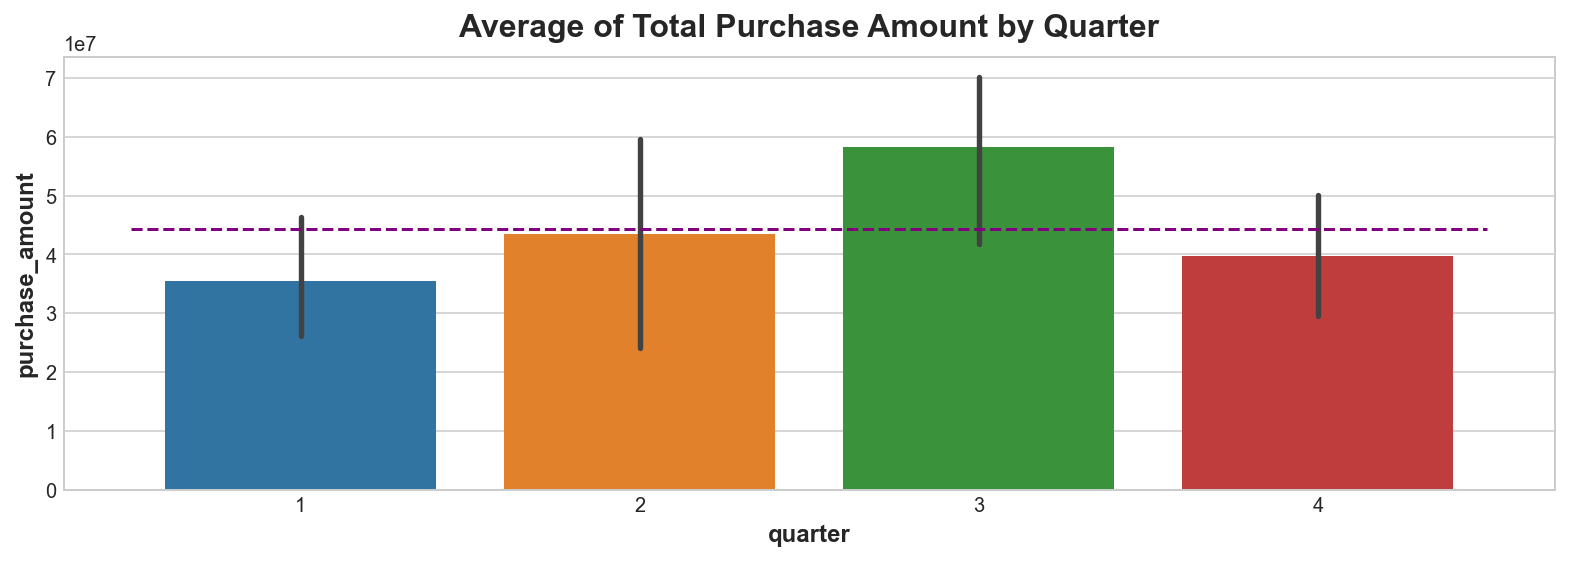

In [46]:
# visualize quarters
ex.q5_viz()

Looks like first and third quarter are significantly different from the quarterly mean of purchase amount. In the first quarter purchase amounts are much lower and in the third quarter they are higher. Let's check this observation with a statistical test. We'll run a sample T-test to compare mean of the sample against the mean of the population.

$H_0$: The quarterly purchase amount of each quarter are not significantly different from overall mean quarterly purchase amount.

$H_a$: The quarterly purchased amount of each quarter are significantly different from overall quarterly purchase amount.

In [221]:
# run t-test
ex.q5_ttest()

,T-value,P-value
Quarter,,
1.00,-2.14,0.08
2.00,0.09,0.93
3.00,1.81,0.12
4.00,-0.56,0.59


Despite the obvious difference in the quarterly purchase amount on the bar chart, statistical test disproved this statement. We fail to reject the null hypothesis because the difference in means is not significant.

#### Takeaways:
- Highest sales are in the 3rd quarter.
- Lowest sales are in the 1st quarter.
- Average qurterly sales per each quarter are not significantly different from the overall average quarterly sales.

<h3 style="color:#2596be;">Data Exploration Takeaways</h3> 

__Is there any trend at all?__
- Our target variable `purchase_amount` looks more like `noise` data that is extremely hard to predict using traditional statistic methods.
- Daily transactions look very messy and we can not see any pattern, trend, seasonality.
- There is lots of missing data in 2017. It would negatively affect models, and provide incorrect information about the purchase amount. That's why we removed 2017 and add one year to each year from 2014 till 2016.

__We can see it!__
- After calculating the total monthly purchase amount we observed a clear positive trend in our taget variable. Specially during 2016. 
- In the beginning of 2018 the sales went down a lot. We don't know for sure if the beginning of 2018 was also affected by missing data or it is a real decrease in sales for Cisco. 
- The end of 2019 and beginning of 2020 there bring an increase in sales. This is the start of COVID-19 pandemic. 
- Starting the middle of 2020 period sales drop back to the trend and even lower. If the values in validate and test sets continue to descrease, our future model going to overestimate the total purchase amount.

__Customer types__
- Cisco customers represented in DIR data set are divided into following groups:
    * Local Governments - 36.8%
    * Independent School Districts - 31.9 %
    * Higher Education Institutions - 21.1%
    * State Agencies - 9.8%
    * Other public agencies - 0.4%
    
__Trends for customer types__
- Local Governments and State Agencies follow the same trend.
- Higher Educational Institutions have less obvious trend line.
- Higher Educational Institutions have a negative trend after 2018.
- - School districts where constantly buying Cisco products even before COVID-19. But since the beginning of pandemic their purchase amount at least doubled.
    
__Daily purchase amounts__
- All purchase amounts per day of the week were significantly different from the average weekly purchase amounts.
- Week days have higher sales than the average and weekend days almost don't have sales.
- Monday, Tuesaday and Wednesday seem to have same average amount of purchase amounts.
- Friday has the highest average purchase amount among all days of the week.

__Monthly purchase amounts__
- The highest purchase amounts are happening in July, followed by April, October and June.
- The lowest purchase amounts happen on February.
- March has almost the same results as average purchase amounts, but there was peak in purchase amounts on March, 2020 when pandemic just started, it might happened that March is typically low on purchase amounts.
- April results might be affected by beginning of pandemic, too.

__Quarterly purchase amounts__
- Highest purchase amounts are in the 3rd quarter.
- Lowest purchase amounts are in the 1st quarter.
- Average qurterly purchase amounts per each quarter are not significantly different from the overall average quarterly purchase amounts.

__Pandemic observations__
- In the beginning of the pandemic there was a spike in purchase amounts.

<h3 style="color:#2596be;">First Modeling Iteration</h3> 

To prepare the data set for time series modeling we created the data frame that contains the information only about the date and purchase amount only. The `purchase_amount` is the total sale number by the end of the day. We removed all information about the customers, in this case our models can predict the `purchase_amount` based on the date only.

In [366]:
reload(tsmd)

<module 'src.ts_models_d' from '/Users/nadina/codeup-data-science/cisco-post-mvp/src/ts_models_d.py'>

In [367]:
# show first 3 rows of our train data
tsmd.X_train.head(3)

,purchase_amount
order_date,
2015-05-07,657.75
2015-05-08,0.00
2015-05-09,0.00


We going to train our models on the train set, confirm the results with the validation set. Then we pick the best model based on the validation results and use it to make our predictions. To remind you, our data is split based on the date and our sets are:
- `train` set contains data from Jan, 1 2018 till Dec, 31 2021
- `validate` set contains data from Jan, 1 2022 till Jun, 30 2022
- `test` set contains data from July, 1 2022 till November, 29 2022

### Data evaluation

To evaluate the model performance we going to use __RMSE score__. This score calculates the absolute error. The lower is RMSE score, the better is model performance. The RMSE score should not be higher than the baseline's model score. __The baseline model__ is the model where all values are the same. In our case it is the average daily sale amount. We going to evaluate our model on the validate set to see if it has good predicting power.

In [266]:
reload(wr)

<module 'src.wrangle' from '/Users/nadina/codeup-data-science/cisco-post-mvp/src/wrangle.py'>

In [277]:
reload(tsmd)

<module 'src.ts_models_d' from '/Users/nadina/codeup-data-science/cisco-post-mvp/src/ts_models_d.py'>

In [278]:
tsmd.train.tail(1)

,customer_name,customer_type,customer_city,reseller_name,shipped_date,year,quarter,month,week,day_of_week,day_of_year,month_name,day_name,purchase_amount
order_date,,,,,,,,,,,,,,
2021-12-31,Houston TranStar,Local Government,Houston,"Presidio Networked Solutions Group, LLC",2022-01-04,2021,4,12,52,4,365,December,Friday,712.76


In [368]:
# show the baseline value
tsmd.baseline

549159.2831427393

purchase_amount -- RMSE train: 799205
purchase_amount -- RMSE validate: 799071


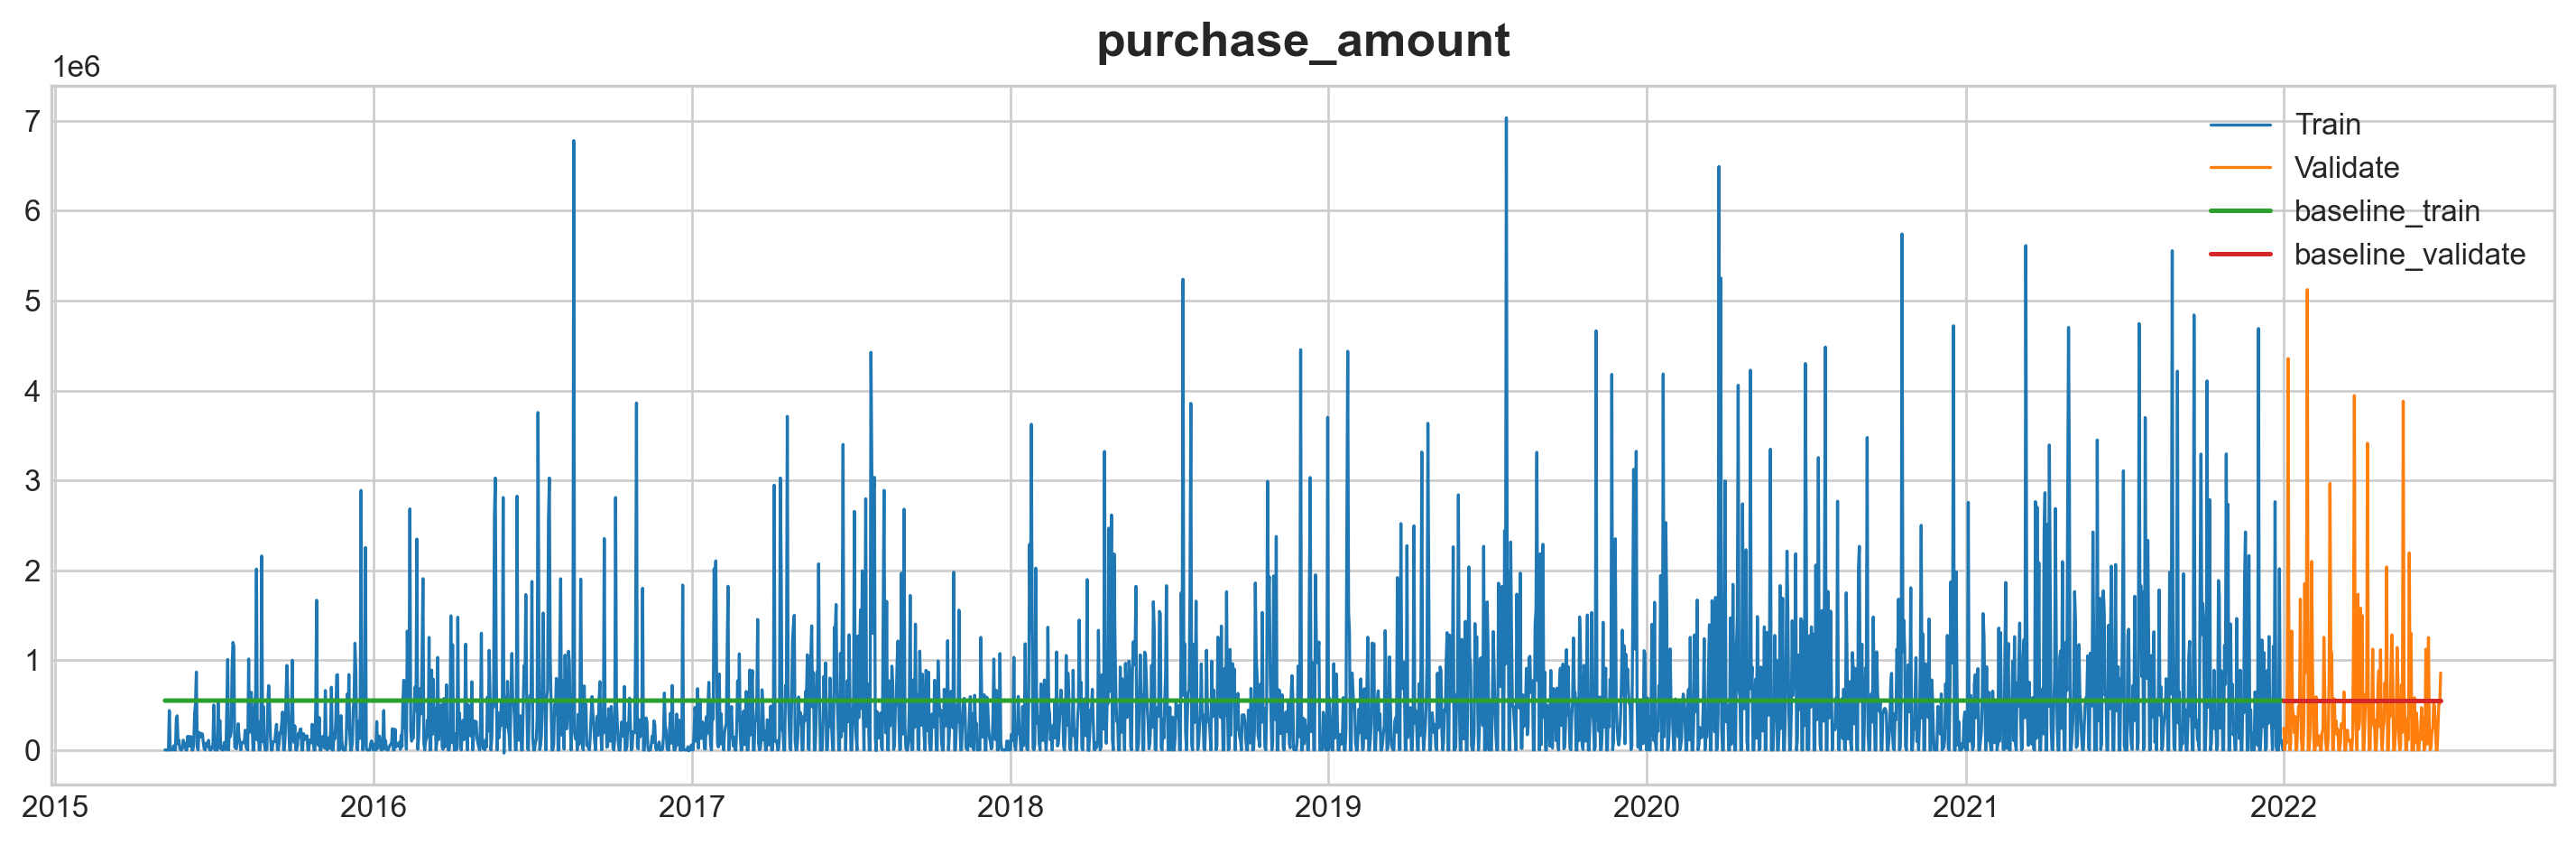

In [369]:
# evaluate and plot baseline
tsmd.evaluate()

Because we don't observe any trend in our data we can not use Holt's Linear Trend models. We decided to try ARIMA models, that rely on moving average and stationarity of the data. The results of ARIMA models you can see below.

In [370]:
# create ARIMA models and show their scores
tsmd.create_arima_models()

,model_name,train_score,validate_score
0,baseline,799205,799071
1,"ARIMA 1,0,0",None,798850
2,"ARIMA 2,0,0",None,798871
3,"ARIMA 0,0,2",None,798886
4,"ARIMA 0,0,5",None,799078


The first three models beat baseline score but just by a little bit, and they definately are not good.

The next step we took is building regression model with XGBoost Regressor. 

In [371]:
# create XGBoost model
tsmd.run_xgboost()

,model_name,train_score,validate_score
0,baseline,799205,799071
1,"ARIMA 1,0,0",None,798850
2,"ARIMA 2,0,0",None,798871
3,"ARIMA 0,0,2",None,798886
4,"ARIMA 0,0,5",None,799078
5,XGBoost,693165,752888


XGBosst Regressor model beats the baseline's RMSE score and outperformes all other models that we've created. We are going to use XGBoost Regressor for our test data set.

,Baseline,XGBoost
Train RMSE,"799,205.00","693,165.00"
Validate RMSE,"799,071.00","752,888.00"
Test RMSE,"519,155.01","476,882.40"


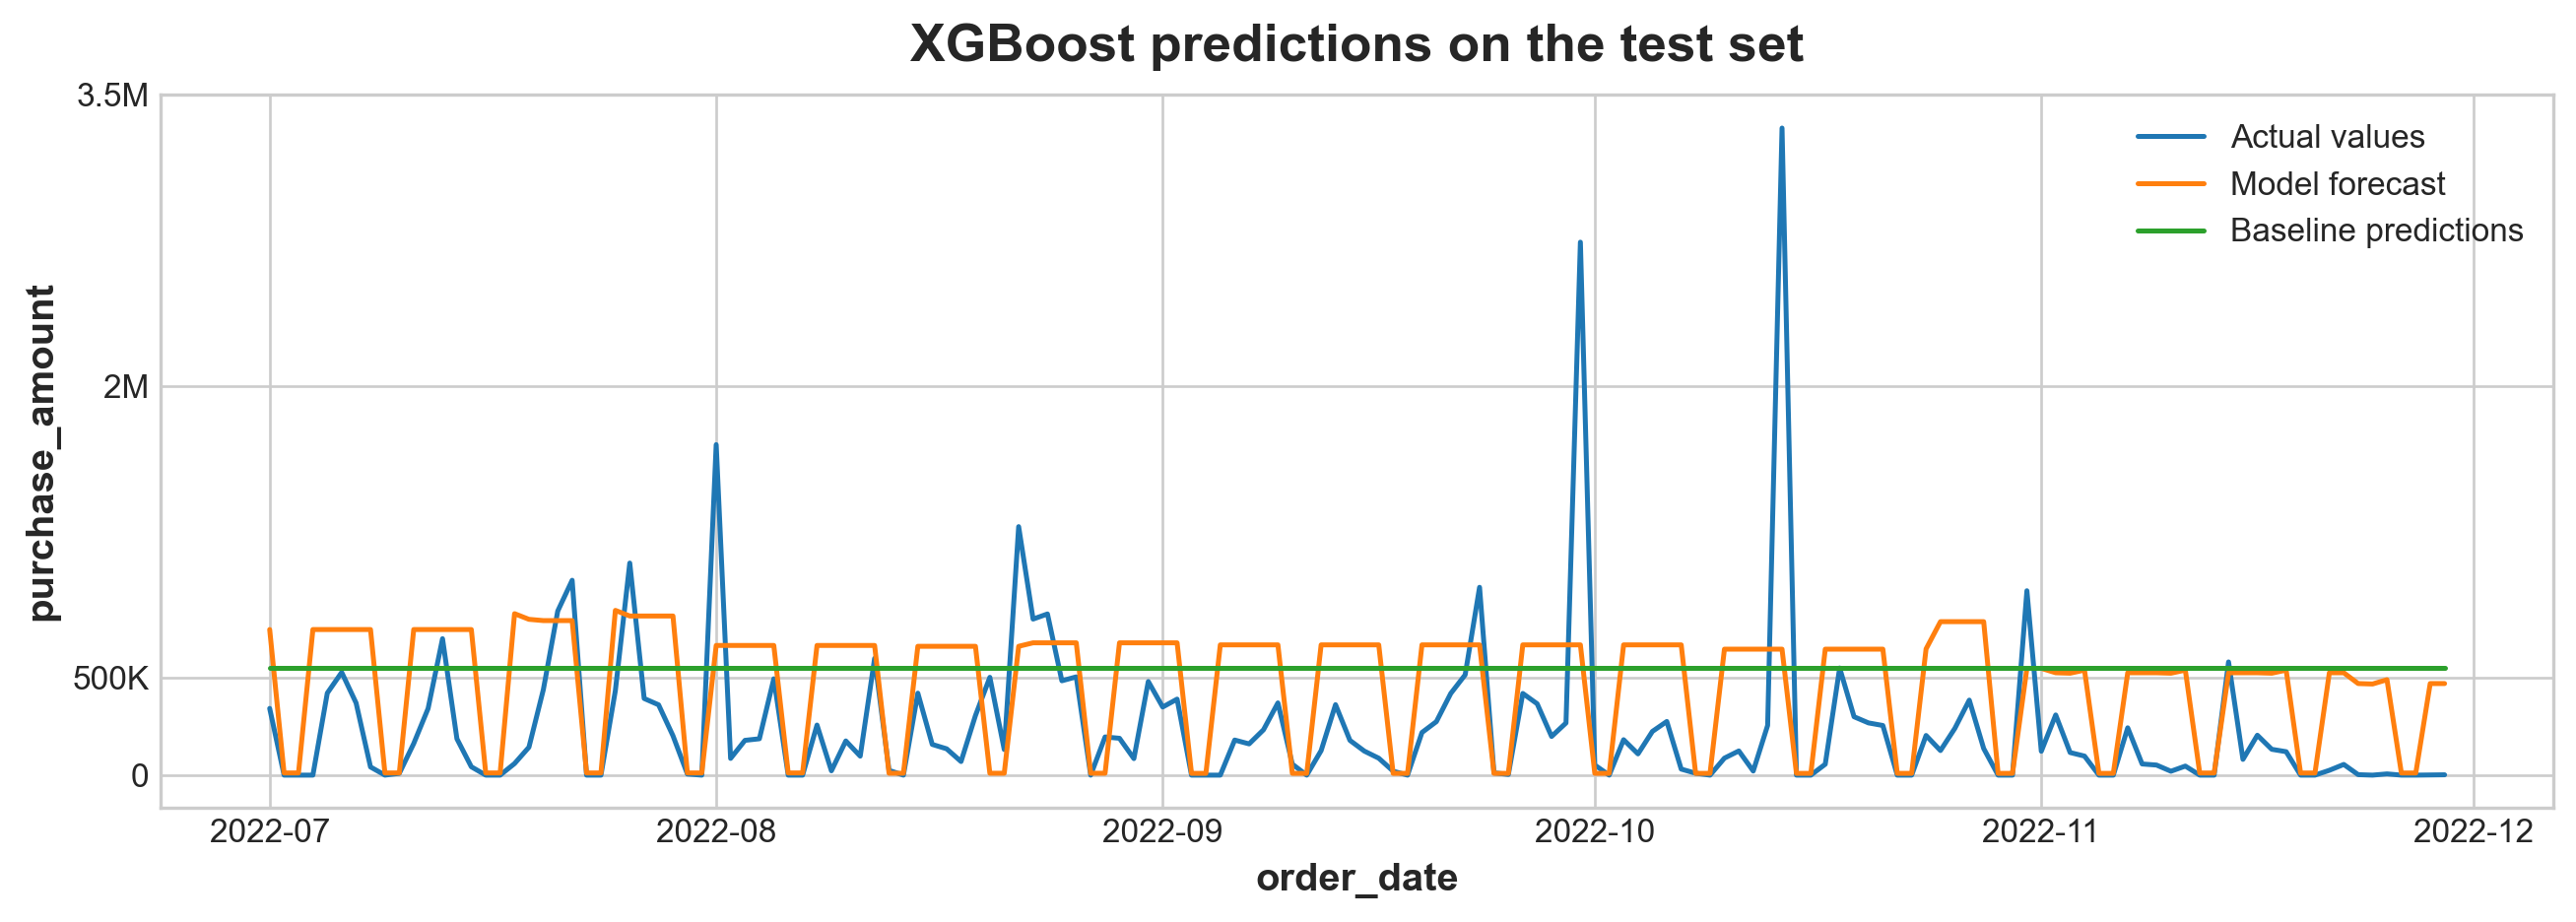

In [372]:
# show scores and predictions of the test set
tsmd.run_test_model(save_results=True)

In [373]:
pr = pd.read_pickle('predictions.pickle')

In [374]:
pr.y.sum(), pr.baseline.sum(), pr.forecast.sum()

(38028255.47, 83472211.03769636, 72002410.0)

In [376]:
72107090.0 - 38028255.47

34078834.53

In [307]:
83167060.0 - 38028255.47

45138804.53

In [365]:
79102904.0 - 38028255.47

41074648.53

In [308]:
import src.ts_models_w as tsmw

In [357]:
reload(wr)

<module 'src.wrangle' from '/Users/nadina/codeup-data-science/cisco-post-mvp/src/wrangle.py'>

In [358]:
reload(tsmw)

<module 'src.ts_models_w' from '/Users/nadina/codeup-data-science/cisco-post-mvp/src/ts_models_w.py'>

In [359]:
# show the baseline value
tsmw.baseline

3836224.762413793

purchase_amount -- RMSE train: 2506573
purchase_amount -- RMSE validate: 2212293


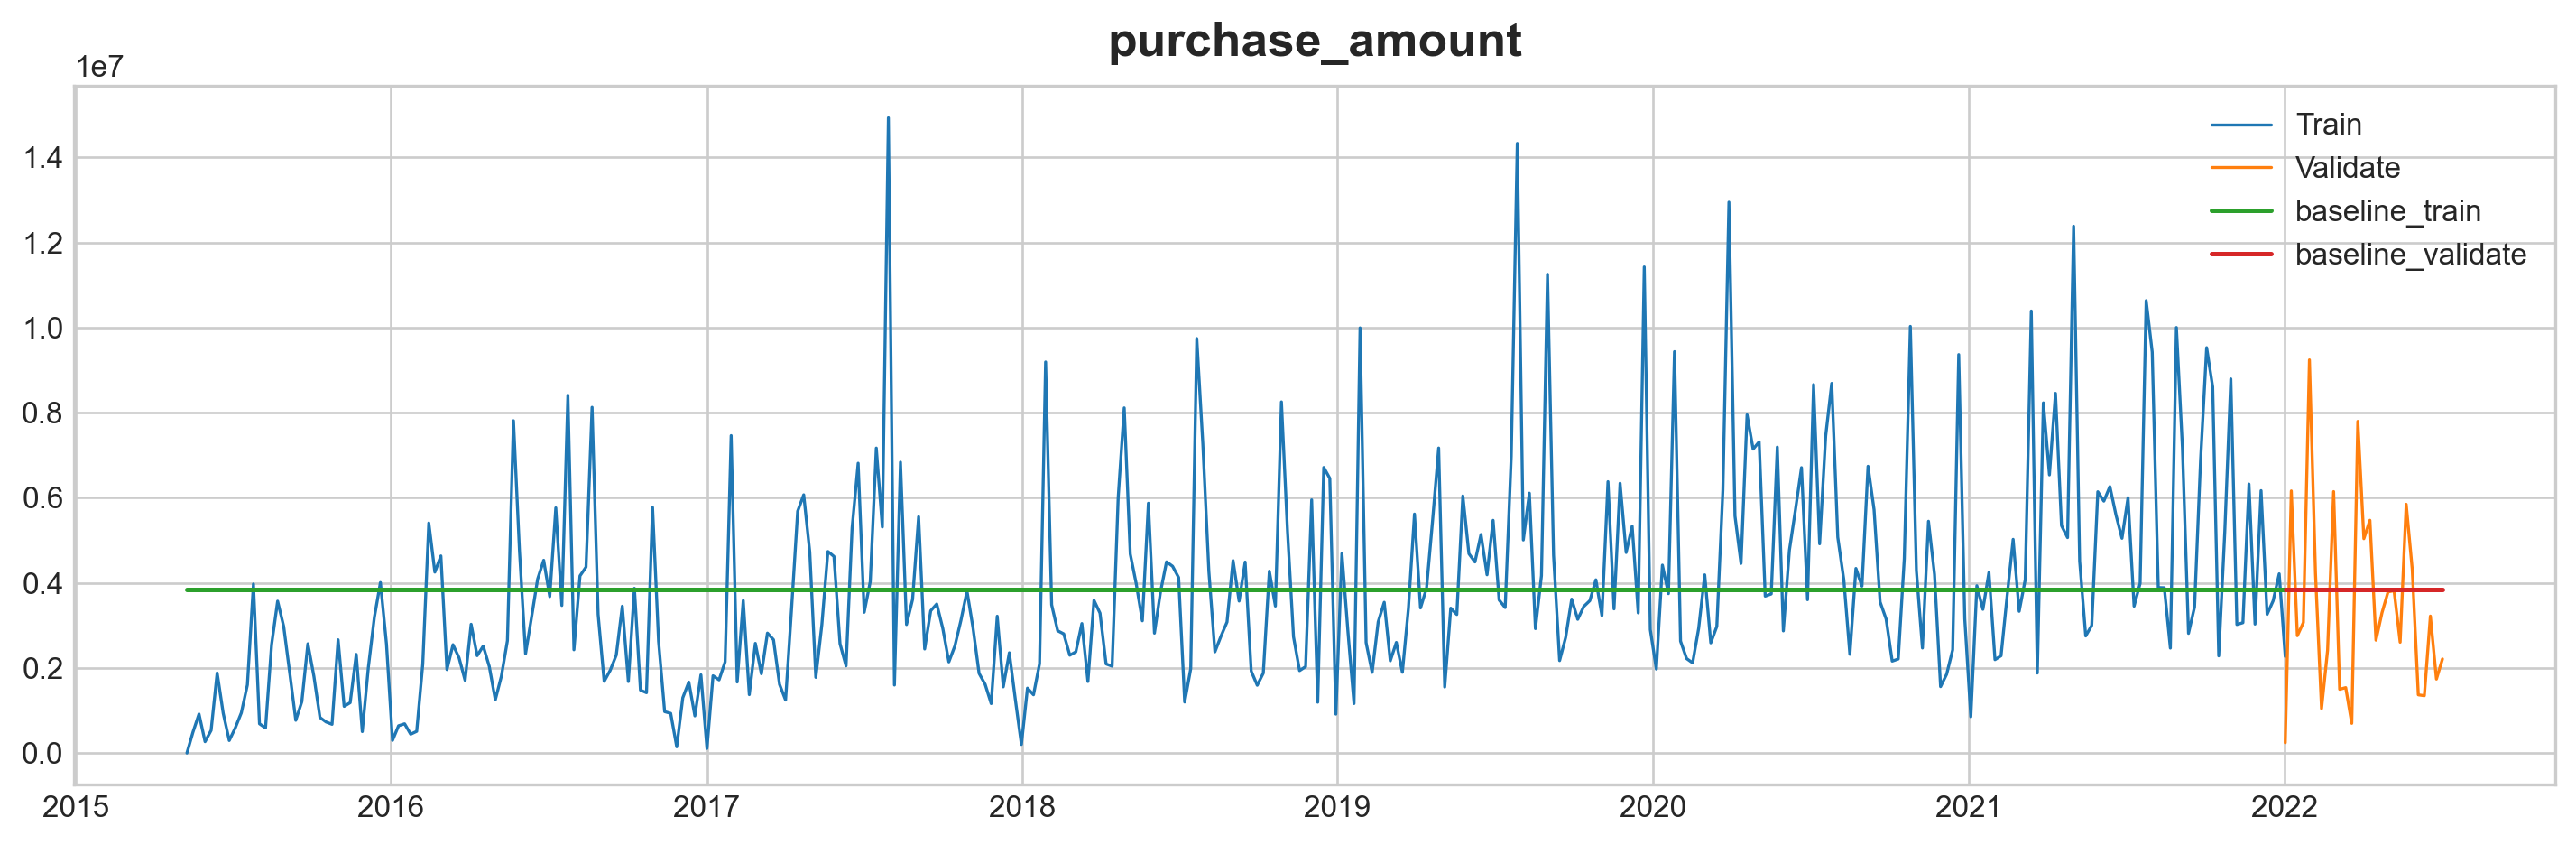

In [360]:
# evaluate and plot baseline
tsmw.evaluate()

In [299]:
# create ARIMA models and show their scores
#tsmw.create_arima_models()

In [361]:
# create XGBoost model
tsmw.run_xgboost()

,model_name,train_score,validate_score
0,baseline,2506573,2212293
1,XGBoost,2215557,2384436


,Baseline,XGBoost
Train RMSE,"2,506,573.00","2,215,557.00"
Validate RMSE,"2,212,293.00","2,384,436.00"
Test RMSE,"2,467,333.02","2,093,292.12"


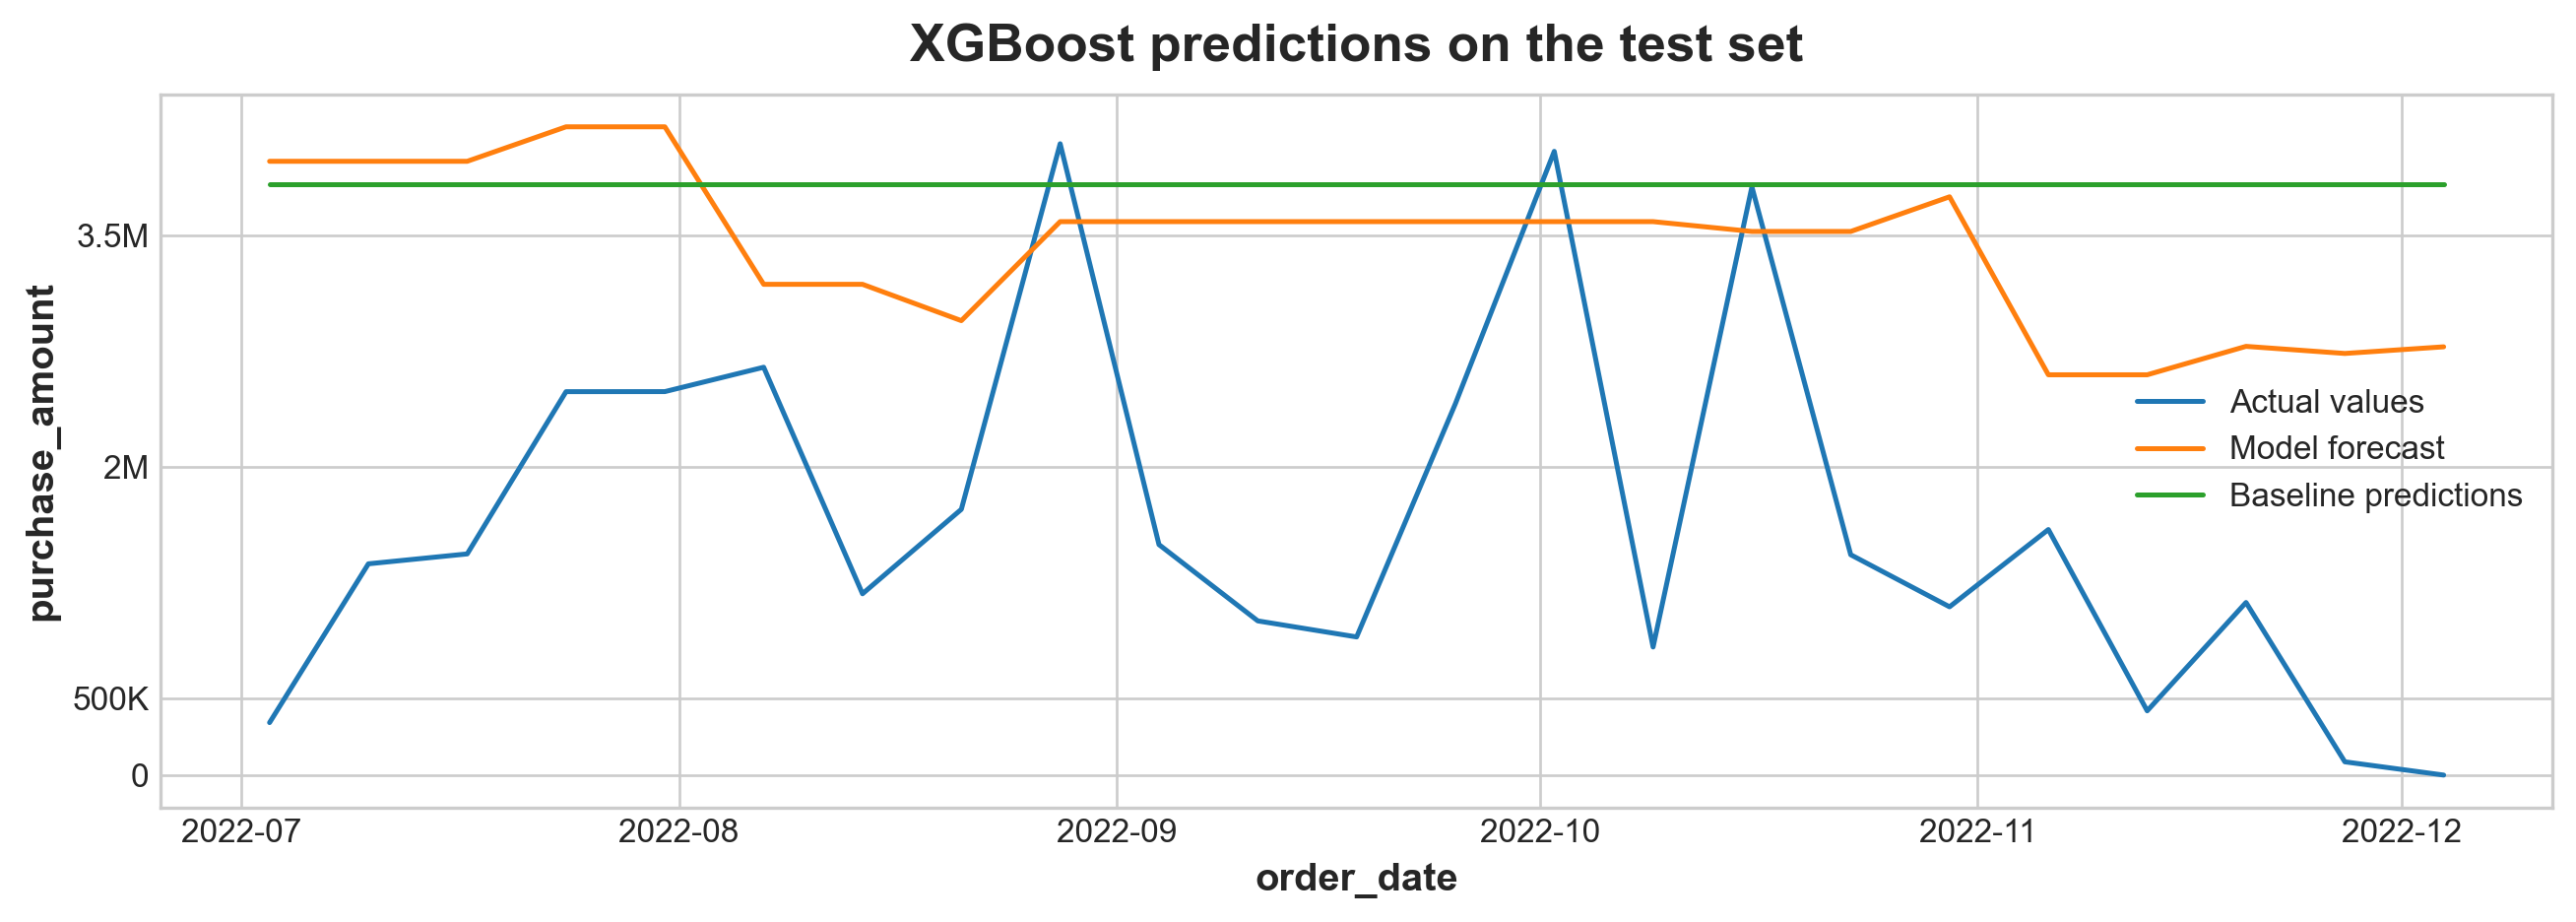

In [362]:
# show scores and predictions of the test set
tsmw.run_test_model(save_results=True)

#### Modeling summary

- Our model beats a baseline on all train, validation and test sets. Anyway, there is much more work to do. We'd like to improve results by making weekly/monthly resamples hoping find some seasonality. We'd like to remove the some pandemic sales anomalies as well. If this won't improve model performance, our next step is going to be splitting data on 5 different sets based on the customer type and make predictions for every set.

<h3 style="color:#2596be;">Conclusions and next steps</h3> 

The goals of this project were:
- Explore the historical data of the DIR contracts with Cisco. 
- Create a model for the sales forecast of Cisco with public agencies.

Our model performs better than a baseline model but needs some improvents.

As the next step for this project we'd like to:
- create weekly/monthly resamples hoping find some seasonality and trends
- remove the some pandemic sales anomalies as well

or, as final step
- split data on 5 different sets based on the customer type and mae predictions for every set.